# Generalized Hamiltonian neural net tutorial

In this tutorial we'll walk through how to learn a generalized Hamiltonian decomposition of a nonlinear pendulum with friction. This tutorial will walk through:
1. How to define a **strong** prior on the form of the energy flux of your model.
2. How to learn this model efficiently using the weak form of the governing equations. 


The governing equations for the nonlinear pendulum we consider in this tutorial can be written as,

$$
\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}) = \left(\begin{bmatrix}0 & 1 \\ -1 & 0\end{bmatrix} + \begin{bmatrix}0 & 0 \\ 0 & -0.35 \end{bmatrix} \right) \begin{bmatrix}g \sin(x_1) \\ x_2 \end{bmatrix}.
$$

In [1]:
import torch
import torch.nn as nn
torch.manual_seed(42)
import numpy as np
import math 
import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint as odeint

from weakformghnn import GHNN, weak_form_loss, gauss_rbf, ODEFCN

## Generating data
We define the true ODE dynamics and integrate these dyanmcis forward in time. We then add noise to this latent state to simulate noisy measurements.

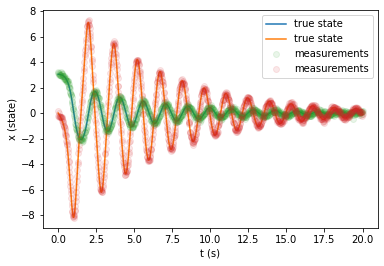

In [2]:
class PendulumODE(nn.Module):
    """ Nonlinear pendulum with friction
    """

    def __init__(self):
        super(PendulumODE, self).__init__()
        self.xl = torch.tensor([-2.5, -0.])
        self.xu = torch.tensor([2.5, 0.])
        self.NDIM = 2
        self.y0 = torch.tensor([[math.pi - math.pi/32, 0.0],])
        self._J = torch.tensor([[0., 1.], [-1., 0.]])
        self._R = 3.5*torch.Tensor([[0., 0.], [0., -0.1]])

    def H(self, x):
        return -2*9.81*torch.cos(x[:, 0]) + 0.5*torch.pow(x[:, 1], 2) - -2*9.81

    def ode(self, t, x):
        with torch.enable_grad():
            if not x.requires_grad:
                x.requires_grad = True
            grad_h = torch.autograd.grad(
                self.H(x).sum(), x, retain_graph=False)[0]
            return torch.mm(grad_h, self._J.T) + torch.mm(grad_h, self._R.T)

    def forward(self, t, x):
        in_shape = x.shape
        x = x.reshape(-1, self.NDIM)
        return self.ode(t, x).reshape(in_shape)

ode = PendulumODE()
t = torch.linspace(0., 20., 1000)
y = odeint(ode, ode.y0, t).squeeze(1)
y_meas = y + torch.randn(y.shape)*0.1
with torch.no_grad():
    plt.plot(t, y, label='true state')
    plt.plot(t, y_meas, 'o',alpha=0.1, label='measurements')
    plt.xlabel('t (s)')
    plt.ylabel('x (state)')
    plt.legend()

## Initializing a generalized Hamiltonian neural network with a strong prior

The GHNN class provides a number of choices for the prior on the generalized Hamiltonian out of the box:

```bash
help(GHNN)

Help on class GHNN in module weakformghnn._src._models:

class GHNN(torch.nn.modules.module.Module)
 |  GHNN(ndim, nhidden, nlayers, prior={'H': 'H0'})
 |  
 |  Main generalized Hamiltonian neural nets class
 |  
 |  INPUTS
 |      ndim < int > : number of input dimensions
 |      nhidden < int > : number of hidden units
 |      nlayers < int > : number of hidden layers
 |      prior < dict > : {
 |                          'H': choices = ['H0', 'H1', None], default = 'H0',
 |                          'dHdt': choices = ['decreasing', 'constant', None], default = None
 |                       }
 |  Desciption of prior information dictionary:
 |      H (strong priors on the form of the Hamiltonian)
 |          'H0': H(x) -> infty as x -> infty, H(x) + H(0) >= 0, H(0) = 0. 
 |              - use if energy is bounded locally ie. damped duffing oscilator)
 |              - makes sense in most cases
 |          'H1': H(x) -> infty as x -> infty, H(0) = 0, H(x) > 0 forall x != 0 
 |              - use if globally stable at x=0 
 |      dHdt (strong priors on the energy flux rate)
 |          'decreasing' : dHdt(x) < 0 along trajectories following dxdt = f(x)
 |          'constant' : dHdt(x) = 0 along trajectories following dxdt = f(x)
 |  
 |  Regularization shemes: 
 |      The forward function takes in an optional argument reg_schemes. This tuple
 |      should contain the names of regularization schemes you would like to use in training.
 |  
 |      The choices for regularization schemes are:
 |          - curl (use when performing curl regularization)
 |          - dhdt (use when imposing a soft energy flux rate prior)
```

We know that the pendulum is globally asymptotically stable and energy decaying. We place a strong prior on the energy decay that guarantees the model is asymptotically stable at $x=0$ and energy decaying

In [3]:
prior = {'H':'H1','dHdt':'decreasing'}
model = GHNN(2, 300, 3, prior=prior)

We can integrate the model forward in time to visualize how it was initialized. Note that, as expected, the ODE is asymptotically stable to $\mathbf{x}=0$. (Although it takes $>5000$ seconds.)

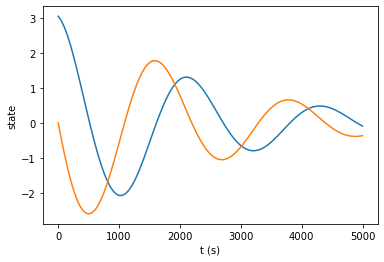

In [4]:
ttmp = torch.linspace(0., 5000, 100)
ytmp = odeint(model, ode.y0, ttmp).squeeze(1)
with torch.no_grad():
    plt.plot(ttmp, ytmp.detach())
    plt.xlabel('t (s)')
    plt.ylabel('state')

## Training the generalized Hamiltonian neural network

We first define some helper functions for training.

In [5]:
def sample_data(t, y, batch_time_int, batch_size):
    """ Draws batch_size samples from y and t with an integration time of batch_time_int
        Assumes all points are evenly spaced 
    inputs:
        t < tensor(num_t,) > 
        y < tensor(num_t, num_start_times, NDIM)  > 
        batch_time_int < int > 
        batch_size < int > 
    outputs:
        t_data < tensor(batch_time_int) > 
        y_data < tensor(batch_time_int, batch_size, NDIM) > 
    """
    num_t = len(t)
    t_data = t[:batch_time_int]
    batch_idx = np.random.choice(np.arange(num_t - batch_time_int + 1),
                                 batch_size, replace=False)
    run_idx = np.random.choice(np.arange(y.shape[1]), batch_size, replace=True)
    y_data = torch.stack(
        [y[batch_idx[i]:batch_idx[i] + batch_time_int, run_idx[i]]
            for i in range(len(batch_idx))], dim=1)
    return t_data, y_data

We will train on GPU here. Note that training on CPU may take a while.

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Running on: %s' % device)

Running on: cuda:0


We will use the squared weak form loss defined by the package. Our test space will be defined by radial basis functions with a shape parameter of 10. Note that we use a curl regularization scheme in place of a parameterization for which $\nabla \wedge \mathbf{R}\nabla H = 0$ by construction.

Note that the weak_form_loss function only requires our model provide estimates for $\dot{\mathbf{x}}$; hence it can be used by any differential model for an ODE. 

In [7]:
epoch = 1000
model.to(device)
rbf_ep = 10 # use a shape parameter of 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

for ep in range(1,epoch+1):
    optimizer.zero_grad()
    t_sample, y_sample = sample_data(t, y_meas.unsqueeze(1), 120, 80)
    t_sample = t_sample.to(device)
    y_sample = y_sample.to(device)
    dydt_pred, r_val = model(t_sample, y_sample, reg_schemes=['curl',])
    c = torch.linspace(t_sample[0], t_sample[-1], 200, device=device)
    psi, psi_dot = gauss_rbf(t_sample, c, rbf_ep)
    reg = torch.pow(r_val[0], 2).mean()
    loss = weak_form_loss(dydt_pred.transpose(1, 0), y_sample.transpose(1, 0), 
                          t_sample, psi, psi_dot) + reg
    if ep % 200 == 0:
        print("Epoch: {:04d}, loss: {:.2f}".format(ep,loss.item()))
    loss.backward()
    optimizer.step()

Epoch: 0200, loss: 2.23
Epoch: 0400, loss: 1.32
Epoch: 0600, loss: 1.21
Epoch: 0800, loss: 1.11
Epoch: 1000, loss: 1.08


## Visualizing the results

Let's now integrate our model forward using torchdiffeq and compare the results of our model to the true solution.

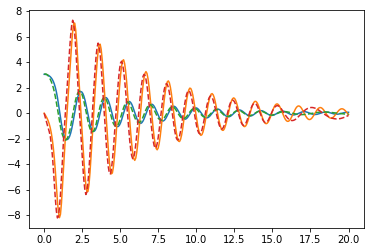

In [8]:
t_eval = torch.linspace(0., 20., 300)
y_pred_final = odeint(model.to('cpu'), ode.y0, t_eval).squeeze(1)
y_true_final = odeint(ode, ode.y0, t_eval).squeeze(1)
with torch.no_grad():
    plt.plot(t_eval, y_true_final.detach(),label='true')
    plt.plot(t_eval,y_pred_final.detach(),'--',label='model')

Generalized Hamiltonia neural nets simultaneously learn an approximation to the ODE and the generalized Hamiltonian in the form of,

$$\dot{\mathbf{x}} = (\mathbf{J}(\mathbf{x}) + \mathbf{R}(\mathbf{x})) \nabla H(\mathbf{x}).$$

We can access the Hamiltonian energy function as model.H. We see we were able to learn the generalzed Hamiltonian energy function. At this point we can run counterfactuals related to the energy flux of our system using our model such as: what if the energy decay rate was halved? or what if the energy was conserved? etc. 

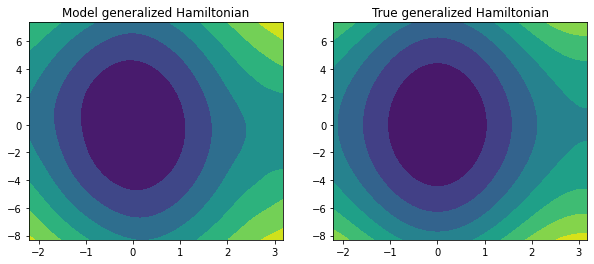

In [10]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
with torch.no_grad():
    num_p = 100
    [min_y1, max_y1] = [y_pred_final[:,0].min()-0.1, y_pred_final[:,0].max()+0.1 ]
    line_y1 = torch.linspace(min_y1, max_y1, num_p)
    [min_y2, max_y2] = [y_pred_final[:,1].min()-0.1, y_pred_final[:,1].max()+0.1 ]
    line_y2 = torch.linspace(min_y2, max_y2, num_p)
    X,Y = torch.meshgrid(line_y1, line_y2)
    z_in = torch.stack([X.flatten(),Y.flatten()], dim=1)
    ax1.contourf(X,Y,model.H(z_in).reshape(X.shape))
    ax1.set_title("Model generalized Hamiltonian")
    ax2.contourf(X,Y,ode.H(z_in).reshape(X.shape))
    ax2.set_title("True generalized Hamiltonian")